# Trevor

In [1]:
from perform_kickstarer_eda import X_train, X_test, y_train, y_test

ks_data shape: (20632, 68)
Categorical columns: ['country', 'currency', 'deadline', 'state_changed_at', 'created_at', 'launched_at', 'category', 'deadline_weekday', 'state_changed_at_weekday', 'created_at_weekday', 'launched_at_weekday', 'launch_to_deadline', 'launch_to_state_change']
Converted boolean column: staff_pick
Dropped 'state_changed_at_weekday' column
Dropping original column: category
Encoded column: category → 25 features
Dropping original column: deadline_weekday
Encoded column: deadline_weekday → 7 features
Dropping original column: created_at_weekday
Encoded column: created_at_weekday → 7 features
Dropping original column: launched_at_weekday
Encoded column: launched_at_weekday → 7 features
Total categorical columns after encoding: 54


In [2]:
from sklearn.model_selection import KFold, cross_val_score
from numpy import set_printoptions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve


Trying max depth 1
Trying rate 0.001
Trying rate 0.01
Trying rate 0.1
Trying rate 0.5
Trying rate 1.0
Trying rate 1.5
Trying rate 2.0
Trying rate 5.0
Trying rate 10.0
Trying max depth 2
Trying rate 0.001
Trying rate 0.01
Trying rate 0.1
Trying rate 0.5
Trying rate 1.0
Trying rate 1.5
Trying rate 2.0
Trying rate 5.0
Trying rate 10.0
Trying max depth 3
Trying rate 0.001
Trying rate 0.01
Trying rate 0.1
Trying rate 0.5
Trying rate 1.0
Trying rate 1.5
Trying rate 2.0
Trying rate 5.0
Trying rate 10.0
Trying max depth 4
Trying rate 0.001
Trying rate 0.01
Trying rate 0.1
Trying rate 0.5
Trying rate 1.0
Trying rate 1.5
Trying rate 2.0
Trying rate 5.0
Trying rate 10.0
Trying max depth 5
Trying rate 0.001
Trying rate 0.01
Trying rate 0.1
Trying rate 0.5
Trying rate 1.0
Trying rate 1.5
Trying rate 2.0
Trying rate 5.0
Trying rate 10.0
Best parameters: learning_rate=0.1, max_depth=5
Best accuracy: 0.9331


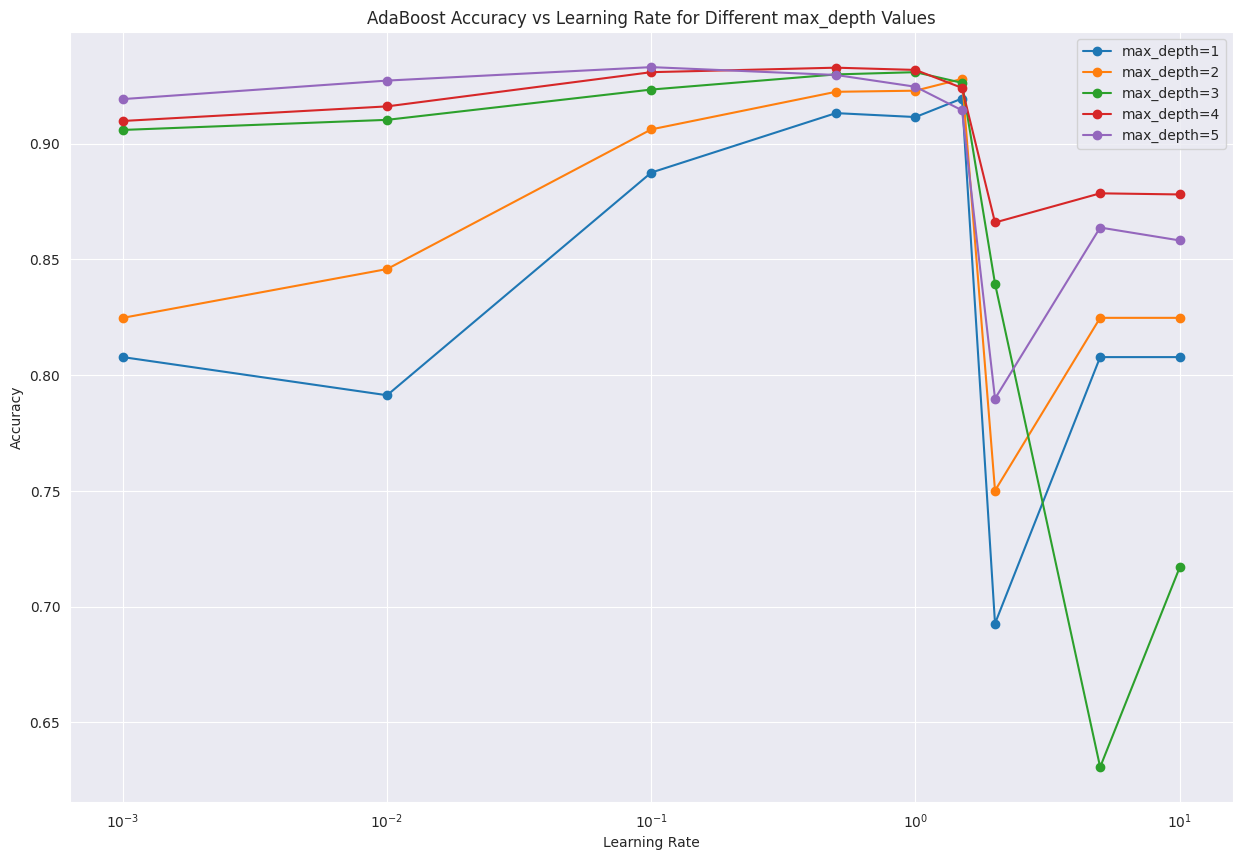

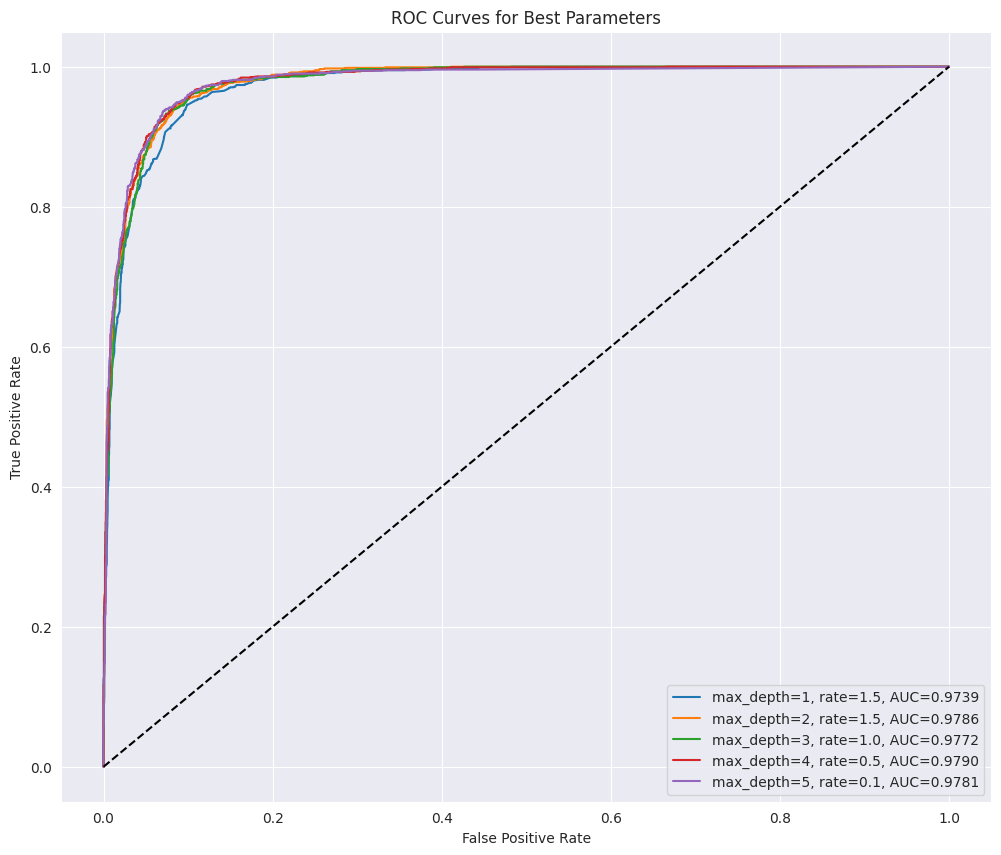

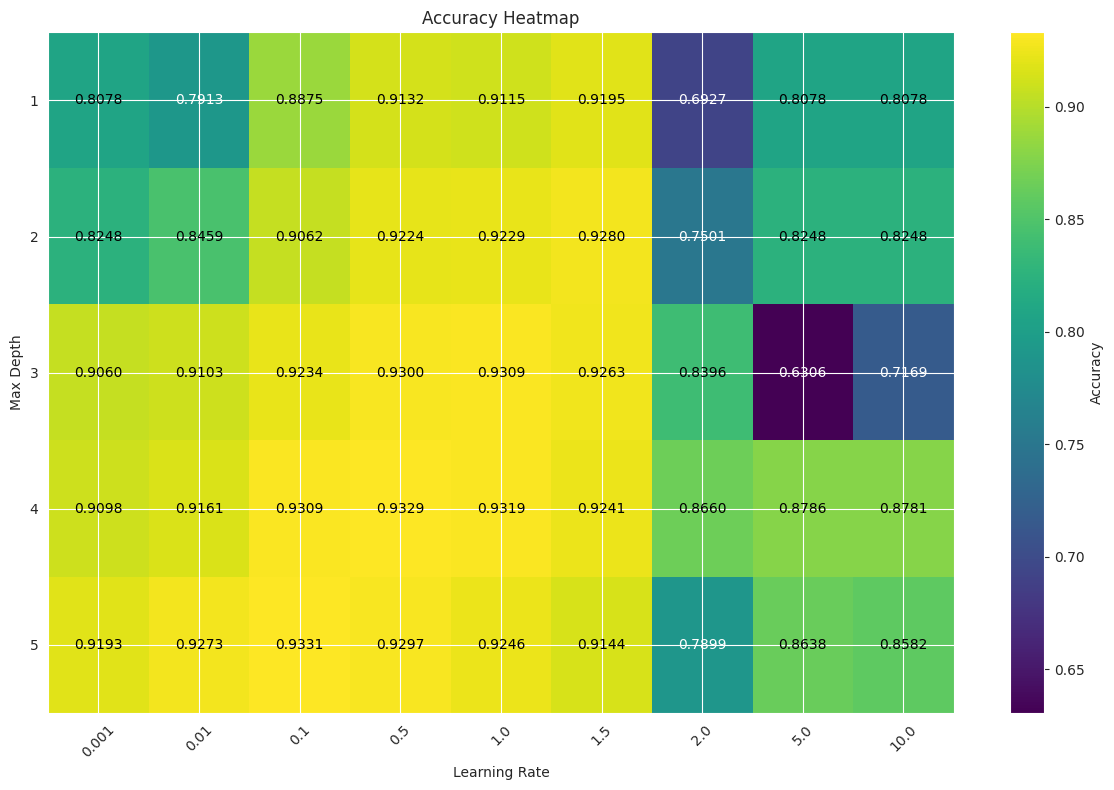

In [3]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Parameters to tune
rates = [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0]
max_depths = [1, 2, 3, 4, 5]

# Initialize tracking variables
results = {}
best_params = {"rate": 0, "depth": 0}
best_accuracy = 0
best_auc = 0

# Perform grid search
for depth in max_depths:
    results[depth] = {"rates": [], "accuracies": [], "aucs": [], "roc_curves": []}
    print(f'Trying max depth {depth}')

    for rate in rates:
        print(f'Trying rate {rate}')
        # Create and train model
        ab_clf = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=depth, random_state=42),
            n_estimators=50,
            learning_rate=rate,
            random_state=42
        )
        ab_clf.fit(X_train, y_train)

        # Get predictions
        ab_y_pred = ab_clf.predict(X_test)
        ab_y_prob = ab_clf.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, ab_y_pred)
        fpr, tpr, _ = roc_curve(y_test, ab_y_prob)
        auc = roc_auc_score(y_test, ab_y_prob)

        # Store results
        results[depth]["rates"].append(rate)
        results[depth]["accuracies"].append(accuracy)
        results[depth]["aucs"].append(auc)
        results[depth]["roc_curves"].append((fpr, tpr))

        # Update best params if needed
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params["rate"] = rate
            best_params["depth"] = depth

        if auc > best_auc:
            best_auc = auc

# Print results
print(f"Best parameters: learning_rate={best_params['rate']}, max_depth={best_params['depth']}")
print(f"Best accuracy: {best_accuracy:.4f}")

# Visualize accuracy results
plt.figure(figsize=(15, 10))

for depth in max_depths:
    plt.plot(rates, results[depth]["accuracies"], marker='o', label=f'max_depth={depth}')

plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('AdaBoost Accuracy vs Learning Rate for Different max_depth Values')
plt.legend()
plt.grid(True)

# Visualize ROC curves for best parameters for each max_depth
plt.figure(figsize=(12, 10))

for depth in max_depths:
    best_idx = np.argmax(results[depth]["accuracies"])
    best_rate = results[depth]["rates"][best_idx]
    fpr, tpr = results[depth]["roc_curves"][best_idx]
    auc = results[depth]["aucs"][best_idx]
    plt.plot(fpr, tpr, label=f'max_depth={depth}, rate={best_rate}, AUC={auc:.4f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Best Parameters')
plt.legend()

# Create heatmap of accuracies
plt.figure(figsize=(12, 8))
heatmap_data = np.zeros((len(max_depths), len(rates)))

for i, depth in enumerate(max_depths):
    for j, rate in enumerate(rates):
        idx = results[depth]["rates"].index(rate)
        heatmap_data[i, j] = results[depth]["accuracies"][idx]

plt.imshow(heatmap_data, cmap='viridis', aspect='auto')
plt.colorbar(label='Accuracy')
plt.xticks(np.arange(len(rates)), [str(rate) for rate in rates], rotation=45)
plt.yticks(np.arange(len(max_depths)), [str(depth) for depth in max_depths])
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')
plt.title('Accuracy Heatmap')

for i in range(len(max_depths)):
    for j in range(len(rates)):
        plt.text(j, i, f"{heatmap_data[i, j]:.4f}",
                 ha="center", va="center", color="white" if heatmap_data[i, j] < 0.8 else "black")

plt.tight_layout()
plt.show()

Trying max depth 1
Trying n_estimators=50
Trying bootstrap=True
Trying max_samples=0.5
Trying max_samples=0.7
Trying max_samples=1.0
Trying bootstrap=False
Trying max_samples=1.0
Trying n_estimators=150
Trying bootstrap=True
Trying max_samples=0.5
Trying max_samples=0.7
Trying max_samples=1.0
Trying bootstrap=False
Trying max_samples=1.0
Trying n_estimators=500
Trying bootstrap=True
Trying max_samples=0.5
Trying max_samples=0.7
Trying max_samples=1.0
Trying bootstrap=False
Trying max_samples=1.0
Trying max depth 2
Trying n_estimators=50
Trying bootstrap=True
Trying max_samples=0.5
Trying max_samples=0.7
Trying max_samples=1.0
Trying bootstrap=False
Trying max_samples=1.0
Trying n_estimators=150
Trying bootstrap=True
Trying max_samples=0.5
Trying max_samples=0.7
Trying max_samples=1.0
Trying bootstrap=False
Trying max_samples=1.0
Trying n_estimators=500
Trying bootstrap=True
Trying max_samples=0.5
Trying max_samples=0.7
Trying max_samples=1.0
Trying bootstrap=False
Trying max_samples=1.

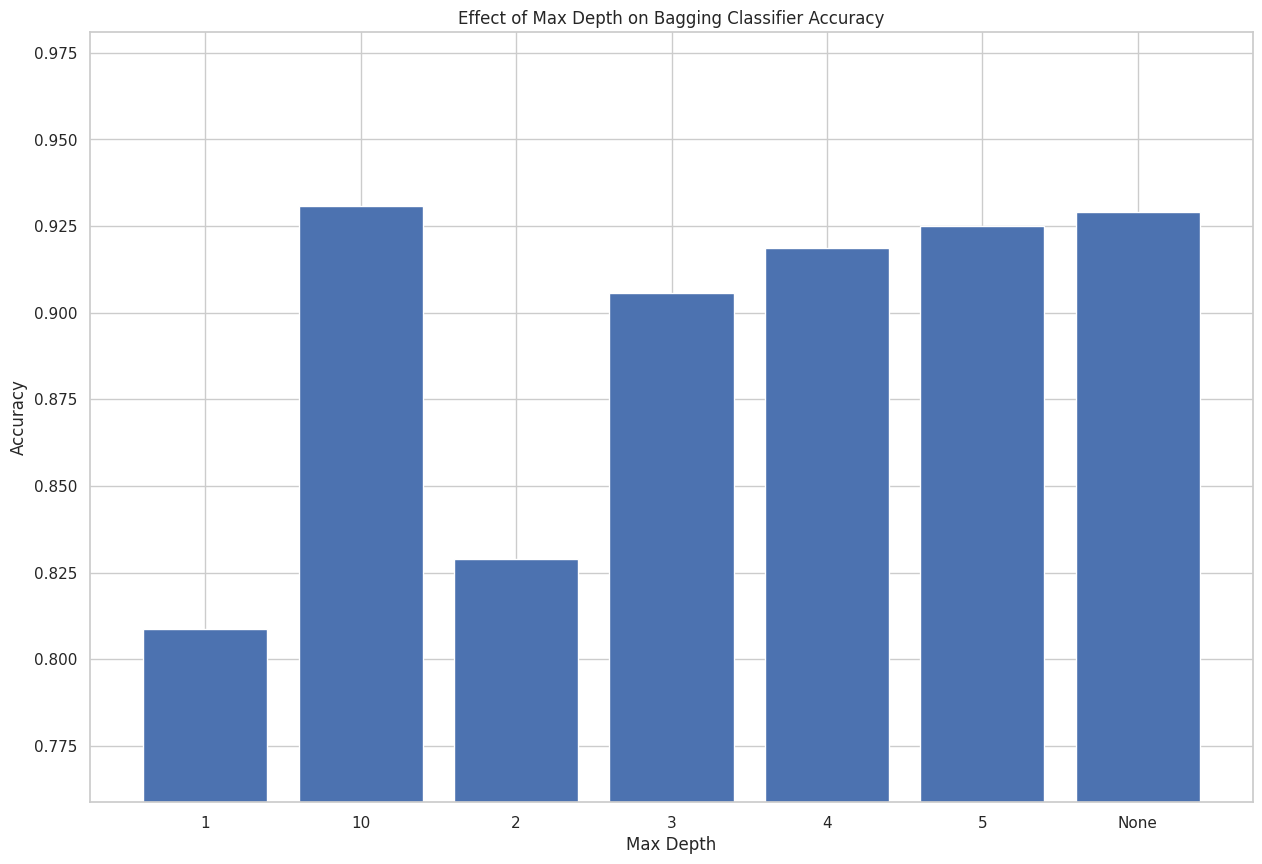

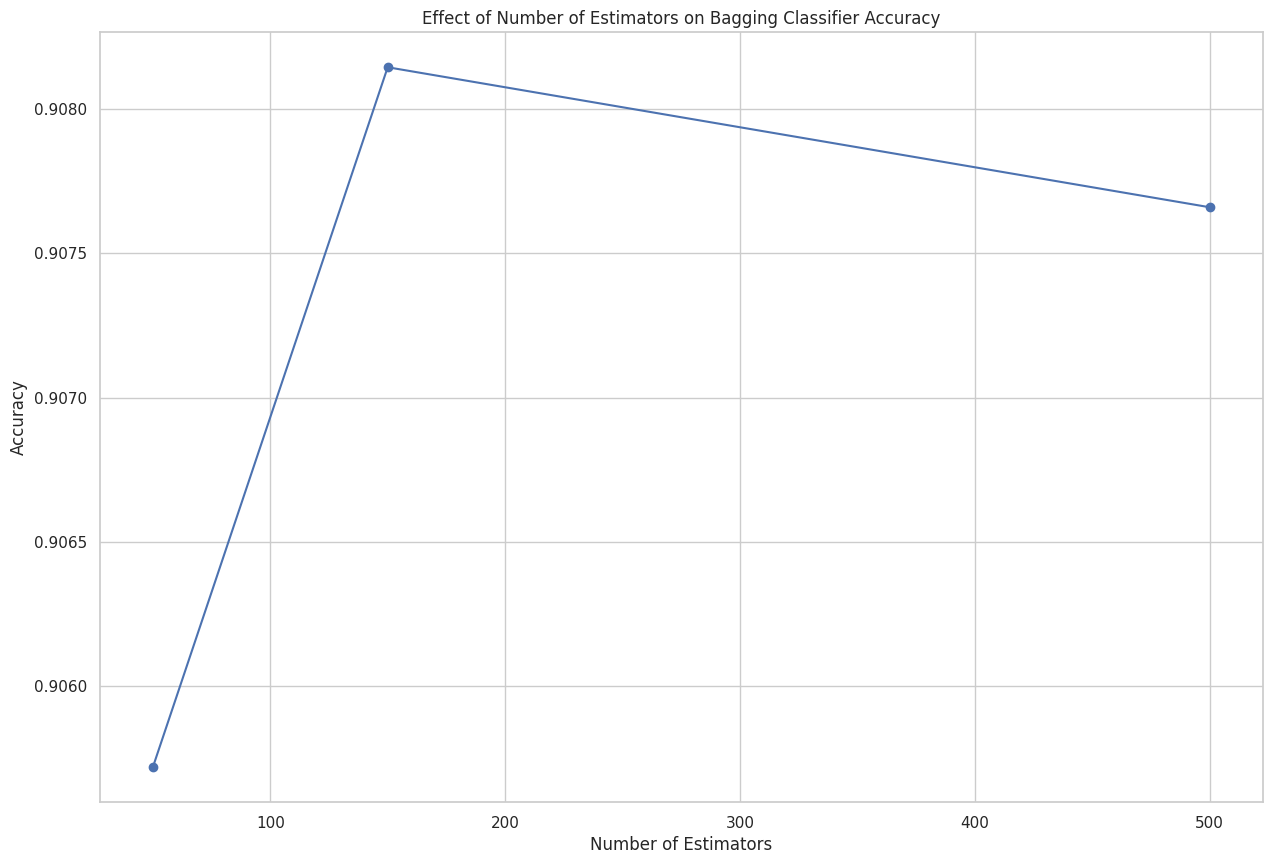

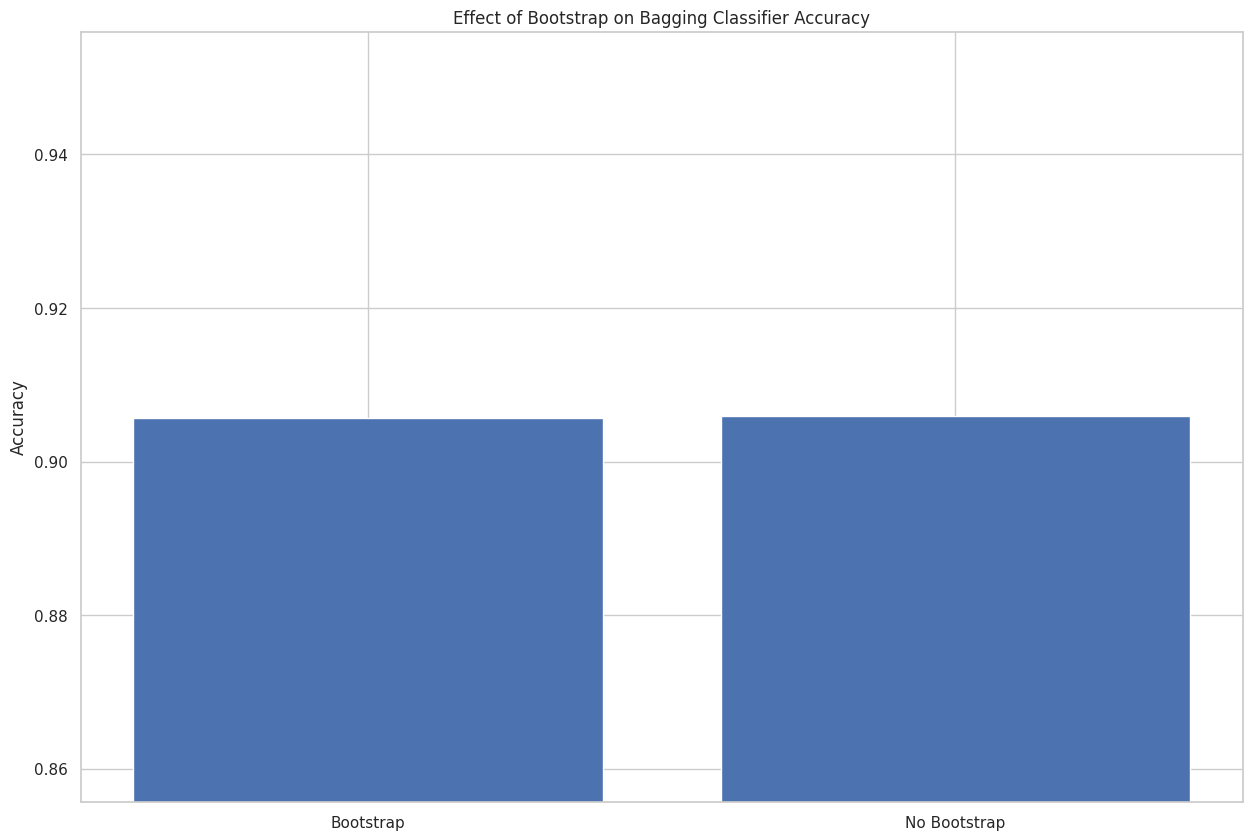

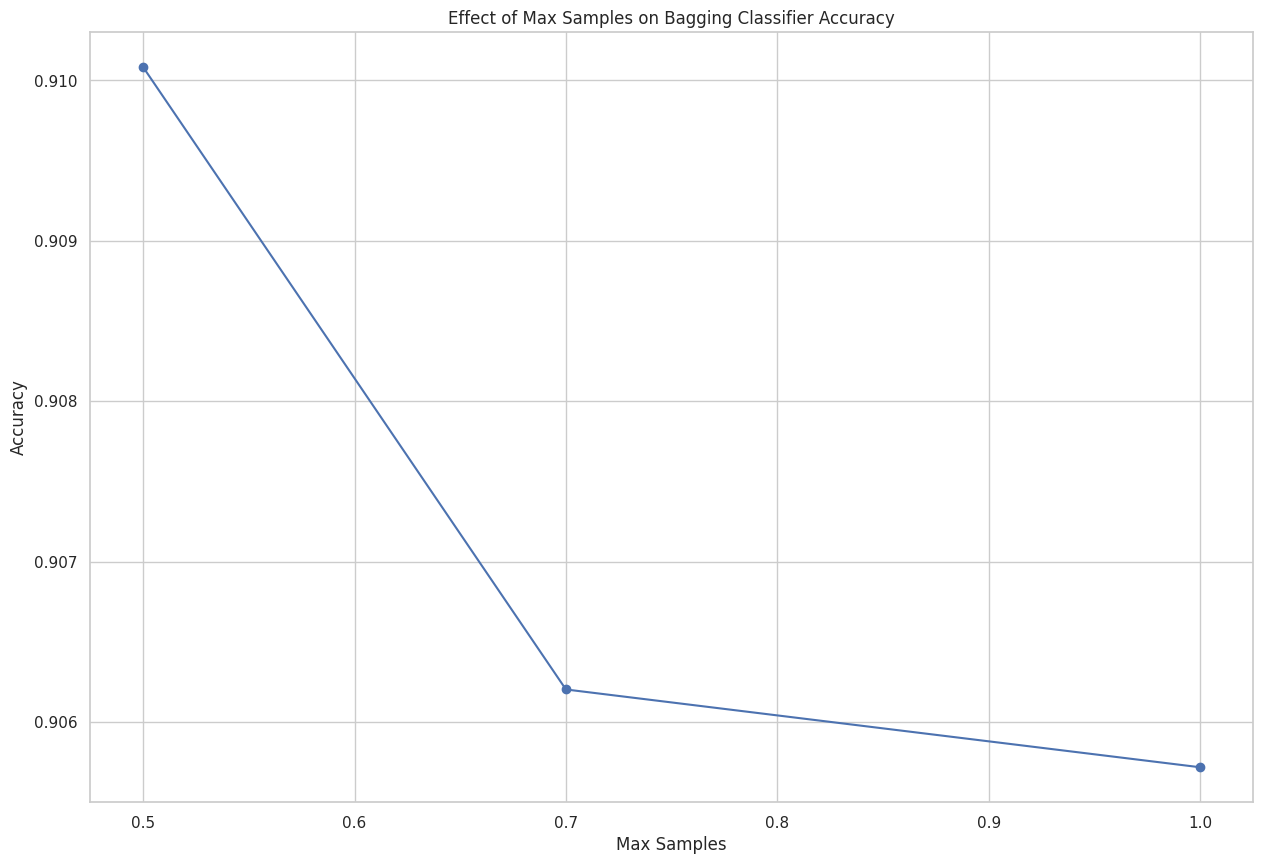

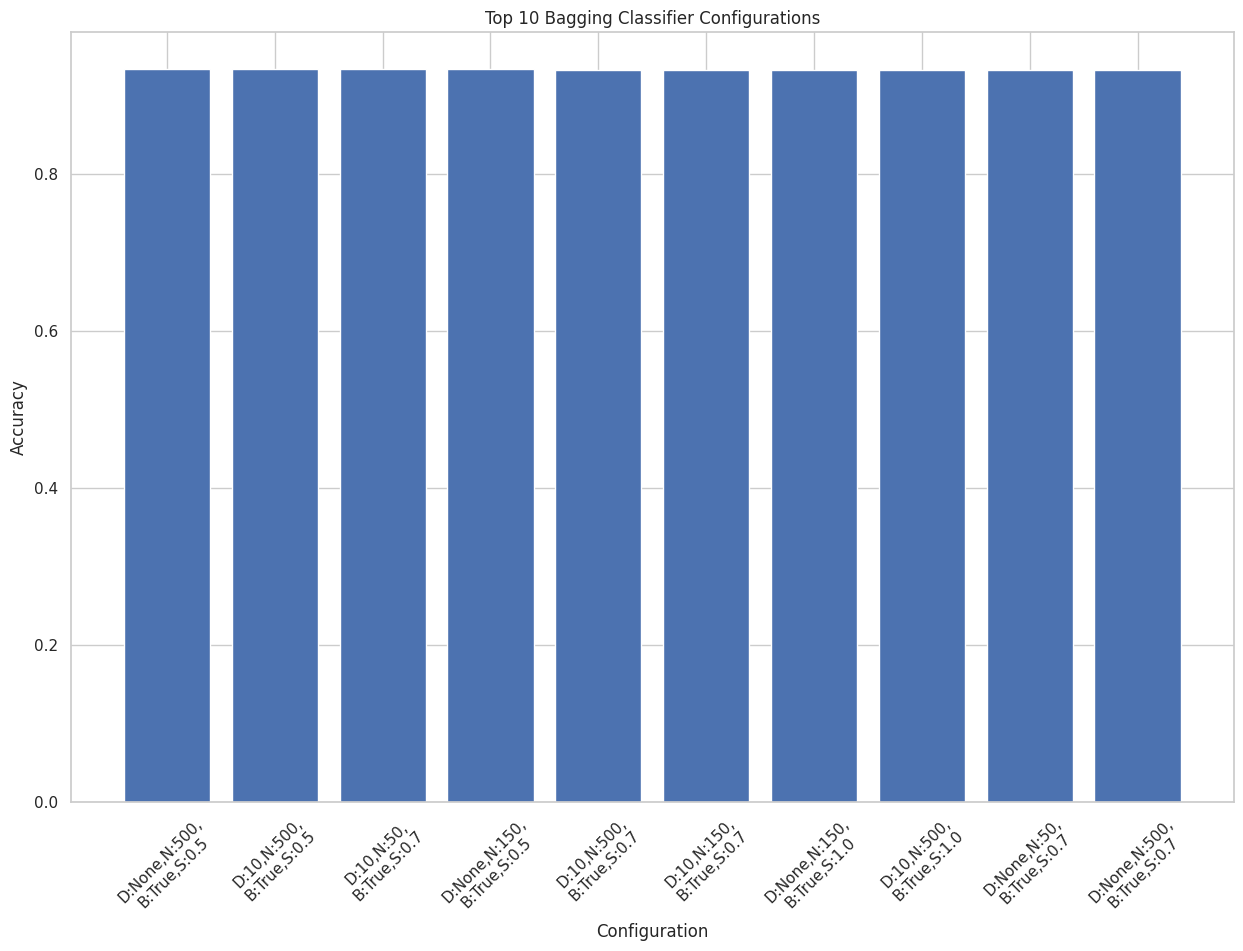

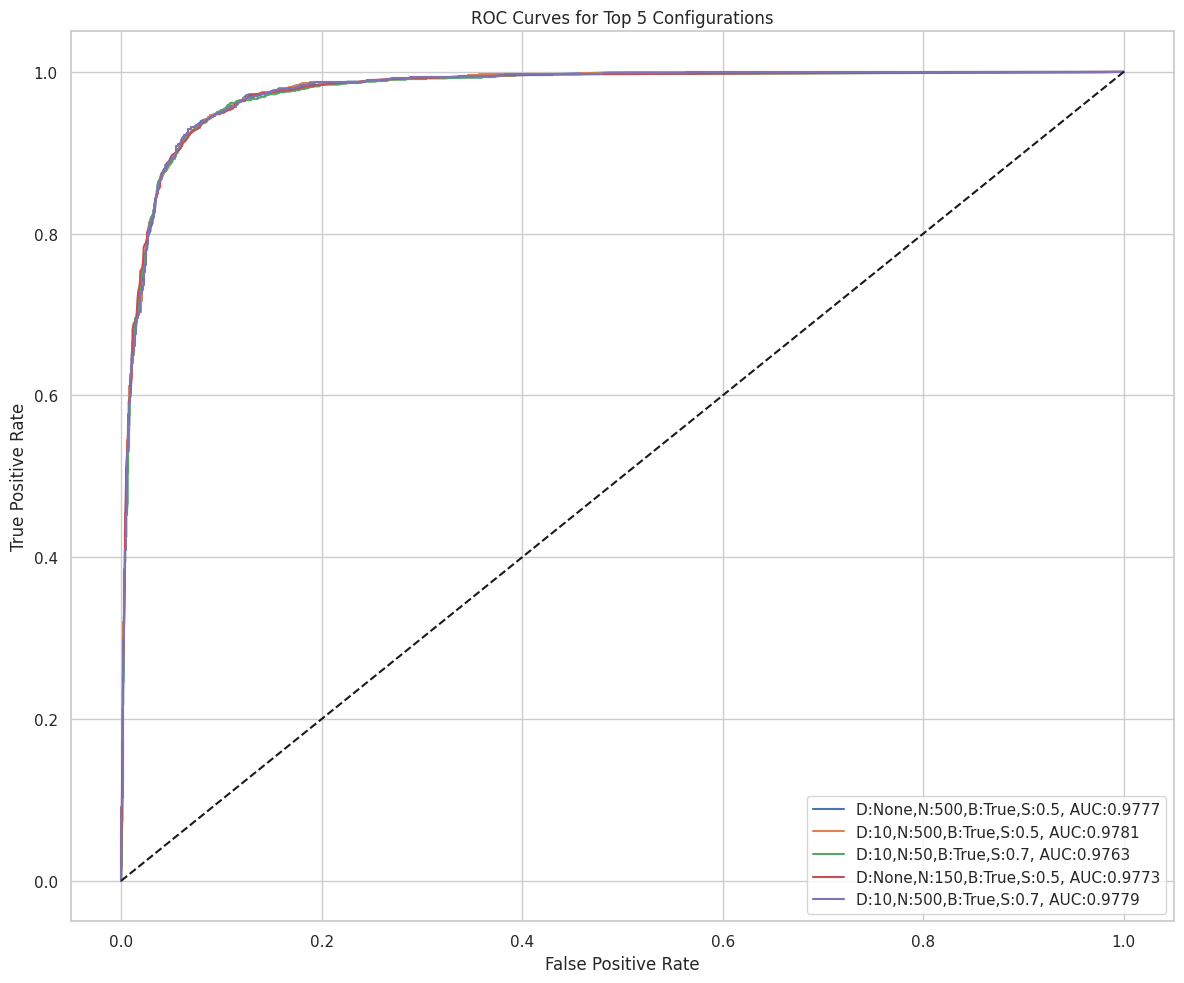

In [9]:
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Parameters to tune
max_depths = [1, 2, 3, 4, 5, 10, None]  # None means nodes are expanded until all leaves are pure
n_estimators_list = [50, 150, 500]
bootstrap_options = [True, False]
max_samples_list = [0.5, 0.7, 1.0]  # Proportion of samples to draw

# Initialize tracking variables
results = {}
best_params = {
    "max_depth": 0,
    "n_estimators": 0,
    "bootstrap": False,
    "max_samples": 0
}
best_accuracy = 0
best_auc = 0

# Create a dictionary to store all results for visualization
all_results = []

# Perform grid search
for max_depth in max_depths:
    print('*' * 20)
    print(f'Trying max depth {max_depth}')
    for n_estimators in n_estimators_list:
        print(f'Trying {n_estimators=}')
        for bootstrap in bootstrap_options:
            print(f'Trying {bootstrap=}')
            for max_samples in max_samples_list:
                # Skip invalid combinations (max_samples only applicable with bootstrap=True)

                if not bootstrap and max_samples != 1.0:
                    continue
                print(f'Trying {max_samples=}')

                # Create base estimator
                base_estimator = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

                # Create and train model
                bag_clf = BaggingClassifier(
                    base_estimator,
                    n_estimators=n_estimators,
                    bootstrap=bootstrap,
                    max_samples=max_samples if bootstrap else 1.0,
                    random_state=42
                )
                bag_clf.fit(X_train, y_train)

                # Get predictions
                bag_y_pred = bag_clf.predict(X_test)
                bag_y_prob = bag_clf.predict_proba(X_test)[:, 1]

                # Calculate metrics
                accuracy = accuracy_score(y_test, bag_y_pred)
                try:
                    fpr, tpr, _ = roc_curve(y_test, bag_y_prob)
                    auc = roc_auc_score(y_test, bag_y_prob)
                except:
                    fpr, tpr = [0, 1], [0, 1]
                    auc = 0.5

                # Store results
                config = {
                    "max_depth": max_depth,
                    "n_estimators": n_estimators,
                    "bootstrap": bootstrap,
                    "max_samples": max_samples,
                    "accuracy": accuracy,
                    "auc": auc,
                    "roc_curve": (fpr, tpr)
                }
                all_results.append(config)

                # Update best params if needed
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {
                        "max_depth": max_depth,
                        "n_estimators": n_estimators,
                        "bootstrap": bootstrap,
                        "max_samples": max_samples
                    }

                if auc > best_auc:
                    best_auc = auc

# Print best results
print(f"Best parameters:")
print(f"  max_depth: {best_params['max_depth']}")
print(f"  n_estimators: {best_params['n_estimators']}")
print(f"  bootstrap: {best_params['bootstrap']}")
print(f"  max_samples: {best_params['max_samples']}")
print(f"Best accuracy: {best_accuracy:.4f}")

# Visualize effect of max_depth with other parameters fixed
plt.figure(figsize=(15, 10))

# Filter results for bootstrap=True, n_estimators=50, max_samples=1.0
filtered_results = [r for r in all_results
                   if r["bootstrap"] == True and
                      r["n_estimators"] == 50 and
                      r["max_samples"] == 1.0]

# Sort by max_depth for visualization
filtered_results.sort(key=lambda x: str(x["max_depth"]))  # Convert None to string for sorting

depth_values = [r["max_depth"] for r in filtered_results]
depth_labels = [str(d) for d in depth_values]
accuracies = [r["accuracy"] for r in filtered_results]

plt.bar(depth_labels, accuracies)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Effect of Max Depth on Bagging Classifier Accuracy')
plt.ylim(min(accuracies) - 0.05, max(accuracies) + 0.05)

# Visualize effect of n_estimators
plt.figure(figsize=(15, 10))

# Filter results for bootstrap=True, max_depth=3, max_samples=1.0
filtered_results = [r for r in all_results
                   if r["bootstrap"] == True and
                      r["max_depth"] == 3 and
                      r["max_samples"] == 1.0]

# Sort by n_estimators
filtered_results.sort(key=lambda x: x["n_estimators"])

n_estimators_values = [r["n_estimators"] for r in filtered_results]
accuracies = [r["accuracy"] for r in filtered_results]

plt.plot(n_estimators_values, accuracies, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Effect of Number of Estimators on Bagging Classifier Accuracy')

# Visualize bootstrap vs no bootstrap
plt.figure(figsize=(15, 10))

# Filter results for max_depth=3, n_estimators=50, max_samples=1.0
bootstrap_true = [r for r in all_results
                 if r["max_depth"] == 3 and
                    r["n_estimators"] == 50 and
                    r["max_samples"] == 1.0 and
                    r["bootstrap"] == True]

bootstrap_false = [r for r in all_results
                  if r["max_depth"] == 3 and
                     r["n_estimators"] == 50 and
                     r["max_samples"] == 1.0 and
                     r["bootstrap"] == False]

labels = ['Bootstrap', 'No Bootstrap']
values = [bootstrap_true[0]["accuracy"] if bootstrap_true else 0,
          bootstrap_false[0]["accuracy"] if bootstrap_false else 0]

plt.bar(labels, values)
plt.ylabel('Accuracy')
plt.title('Effect of Bootstrap on Bagging Classifier Accuracy')
plt.ylim(min(values) - 0.05, max(values) + 0.05)

# Visualize effect of max_samples with bootstrap=True
plt.figure(figsize=(15, 10))

# Filter results for bootstrap=True, max_depth=3, n_estimators=50
filtered_results = [r for r in all_results
                   if r["bootstrap"] == True and
                      r["max_depth"] == 3 and
                      r["n_estimators"] == 50]

# Sort by max_samples
filtered_results.sort(key=lambda x: x["max_samples"])

max_samples_values = [r["max_samples"] for r in filtered_results]
accuracies = [r["accuracy"] for r in filtered_results]

plt.plot(max_samples_values, accuracies, marker='o')
plt.xlabel('Max Samples')
plt.ylabel('Accuracy')
plt.title('Effect of Max Samples on Bagging Classifier Accuracy')

# Create a summary of top 10 configurations
all_results.sort(key=lambda x: x["accuracy"], reverse=True)
top_configs = all_results[:10]

plt.figure(figsize=(15, 10))
config_labels = [f"D:{r['max_depth']},N:{r['n_estimators']},\nB:{r['bootstrap']},S:{r['max_samples']}" for r in top_configs]
accuracies = [r["accuracy"] for r in top_configs]

plt.bar(range(len(config_labels)), accuracies)
plt.xticks(range(len(config_labels)), config_labels, rotation=45)
plt.xlabel('Configuration')
plt.ylabel('Accuracy')
plt.title('Top 10 Bagging Classifier Configurations')

# Visualize ROC curves for top 5 configurations
plt.figure(figsize=(12, 10))

for i, config in enumerate(top_configs[:5]):
    fpr, tpr = config["roc_curve"]
    plt.plot(fpr, tpr,
             label=f"D:{config['max_depth']},N:{config['n_estimators']},B:{config['bootstrap']},S:{config['max_samples']}, AUC:{config['auc']:.4f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Top 5 Configurations')
plt.legend()

plt.tight_layout()
plt.show()

Bagging Classifier Accuracy: 0.9329
AdaBoost Classifier Accuracy: 0.9270


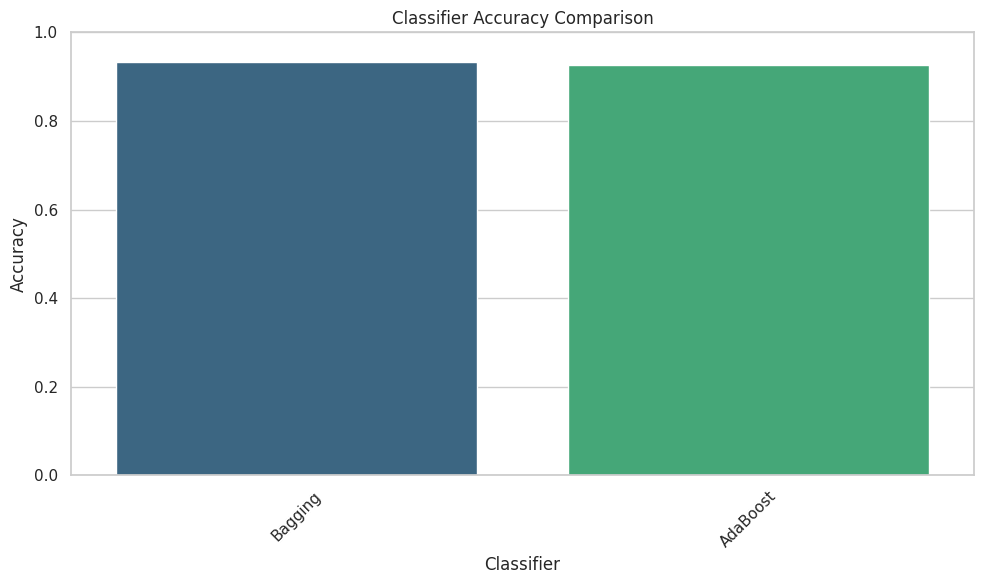

In [11]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_depth=None, random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1,max_samples=0.5, random_state=40)
bag_clf.fit(X_train, y_train)
bag_y_pred = bag_clf.predict(X_test)

ab_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=5, random_state=42), n_estimators=500,
    learning_rate=1.0, random_state=42)
ab_clf.fit(X_train, y_train)
ab_y_pred = ab_clf.predict(X_test)

models_to_compare_in_step_7 = {
    'Bagging': bag_clf,
    'AdaBoost': ab_clf
}

# Calculate and plot the accuracy scores
bag_accuracy = accuracy_score(y_test, bag_y_pred)
ab_accuracy = accuracy_score(y_test, ab_y_pred)
print(f"Bagging Classifier Accuracy: {bag_accuracy:.4f}")
print(f"AdaBoost Classifier Accuracy: {ab_accuracy:.4f}")


sns.set(style="whitegrid")
# Data for plotting
methods = ['Bagging', 'AdaBoost']
accuracies = [bag_accuracy, ab_accuracy]

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=methods, y=accuracies, palette="viridis", hue=methods, legend=False)
plt.title('Classifier Accuracy Comparison')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
